In [ ]:
# kl-divergence
# Last Update: 01/26/2022 by Fei Wei

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


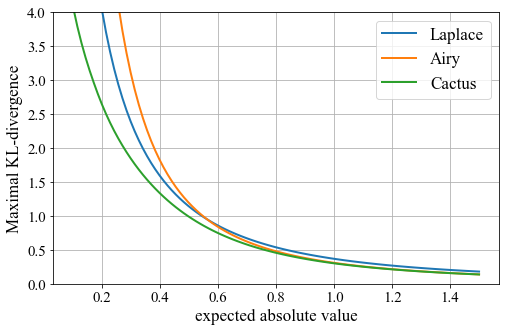

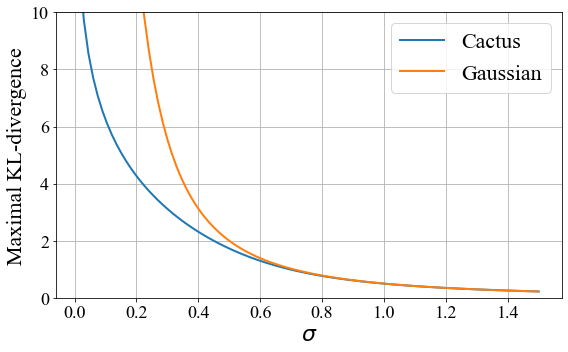

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

plt.rcParams["font.family"] = "Times New Roman"

with open('/home/fwei16/privacy_data/comparison_L1_stds.csv', newline='') as f:
  reader = csv.reader(f)
  stds = np.genfromtxt(next(reader), dtype=np.float32)

with open('/home/fwei16/privacy_data/comparison_L1_cactus.csv', newline='') as f:
  reader = csv.reader(f)
  cactus = np.genfromtxt(next(reader), dtype=np.float32)

with open('/home/fwei16/privacy_data/comparison_L1_airy.csv', newline='') as f:
  reader = csv.reader(f)
  airy = np.genfromtxt(next(reader), dtype=np.float32)
  
with open('/home/fwei16/privacy_data/comparison_L1_laplace.csv', newline='') as f:
  reader = csv.reader(f)
  laplace = np.genfromtxt(next(reader), dtype=np.float32)

plt.figure(figsize=(8,5))
plt.plot(stds,laplace,label = ("Laplace"),linewidth=2)
plt.plot(stds,airy,label = ("Airy"),linewidth=2)
plt.plot(stds,cactus,label = ("Cactus"),linewidth=2)
plt.xlabel("expected absolute value",fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel("Maximal KL-divergence",fontsize=17)
plt.yticks(fontsize=15)
plt.ylim(0, 4)
plt.legend(loc='best',fontsize=17)
plt.grid()
plt.savefig('L1_comparison.eps', format='eps')

with open('/home/fwei16/privacy_data/comparison_L2_stds.csv', newline='') as f:
  reader = csv.reader(f)
  stds = np.genfromtxt(next(reader), dtype=np.float32)

with open('/home/fwei16/privacy_data/comparison_L2_cactus.csv', newline='') as f:
  reader = csv.reader(f)
  cactus = np.genfromtxt(next(reader), dtype=np.float32)

with open('/home/fwei16/privacy_data/comparison_L2_gaus.csv', newline='') as f:
  reader = csv.reader(f)
  gaussian = np.genfromtxt(next(reader), dtype=np.float32)

plt.figure(figsize=(8,5))
plt.plot(stds,cactus,label = ("Cactus"),linewidth=2)
plt.plot(stds,gaussian,label = ("Gaussian"),linewidth=2)
plt.xlabel(r"$\sigma$",fontsize=22)
plt.xticks(fontsize=18)
plt.ylabel("Maximal KL-divergence",fontsize=22)
plt.yticks(fontsize=18)
plt.ylim(0, 10)
plt.legend(loc='best',fontsize=22)
plt.grid()
plt.tight_layout()
plt.savefig('L2_comparison.eps', format='eps')

In [2]:
import tensorflow as tf
import numpy as np
import mpmath as mp
import scipy as sp
import matplotlib.pyplot as plt
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent


def compute_kl_general(noise_type,C,c_type,sen,q):
  
  # note that here the universal parameter for all distributions is the sigma,
  # so if you'd like to use L1-norm, you must choose the approperate sigma!!!
  
 
  if noise_type=="cactus":  # For cactus, we directly use the discrete pmf from file to compute the renyi-divergence with given order
    if c_type==1:
      filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_L1_%.1f.csv' %(sen,C))
      x = np.genfromtxt(filename, dtype=np.float32)
      x = x.reshape(-1)
      filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_L1_%.1f.csv' %(sen,C))
      p = np.genfromtxt(filename, dtype=np.float32)
      p = p.reshape(len(p),1)
      
    if c_type==2:
      filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_L2_%.1f.csv' %(sen,C))
      x = np.genfromtxt(filename, dtype=np.float32)
      x = x.reshape(-1)
      filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_L2_%.1f.csv' %(sen,C))
      p = np.genfromtxt(filename, dtype=np.float32)
      p = p.reshape(len(p),1)
      

    xmax=max(x)
    n = len(x)/2//xmax 
    shift_n = int(n*sen)
    
    right=[]
    r=0.9
    for X in np.linspace(0,sen,int(sen*n)):
      right.append(p[-1]*r**(n*(X)))
    left=right[::-1]
    
    ps = np.concatenate((p,np.array(right)),axis=0).reshape(-1)
    qs = q*np.concatenate((np.array(left),p),axis=0).reshape(-1)+(1-q)*ps
    
  else: # For all other distributions, we sample the pdf to generate the renyi-divergence!
    
    n=500.0 # quantization rate
    xmax=10 # the domin limit
    x=np.linspace(-xmax, xmax, int(2*xmax*n)) # domain of the distribution
    
    if noise_type=="gaussian":
      sigma=C*np.sqrt(np.pi/2)
      f = lambda x: 1/np.sqrt(2*np.pi)/sigma*np.exp(-x**2/2/sigma**2)
    
    elif noise_type == "laplace":
      b = C
      f = lambda x:1/2/b*np.exp(-np.abs(x)/b)
    
    elif noise_type == "airy":
      a0=1.01879
      f = lambda x: np.array(sp.special.airy(2*a0/3/C*np.abs(x)-a0)[0])**2.0/3.0/C/np.array(sp.special.airy(-a0)[0])**2.0
      
    ps = np.array([f(X) for X in x])/n
#     l1 = sum(ps*np.abs(x))
#     print("l1 cost =", l1)
#     l2 = sum(ps*np.power(x,2))
#     print("l2 cost =", l2)
    
    qs = q*np.array([f(X) for X in x-sen])/n+(1-q)*ps
    ps= ps.reshape(-1)
    qs = qs.reshape(-1)
    
  kl = sum(ps*np.log(ps/qs))
  return kl


compute kl for laplace
compute kl for airy


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
<ipython-input-4-b1993d46363d>:33: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(sen_grid, kl_grid_laplace/np.power(sen_grid,2),label = ("Laplace"),linewidth=2)
<ipython-input-4-b1993d46363d>:34: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(sen_grid, kl_grid_airy/np.power(sen_grid,2),label = ("Airy"),linewidth=2)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


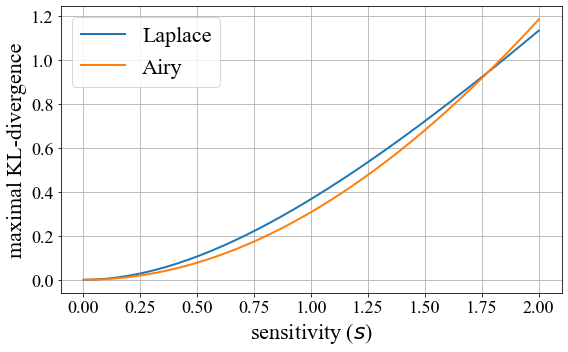

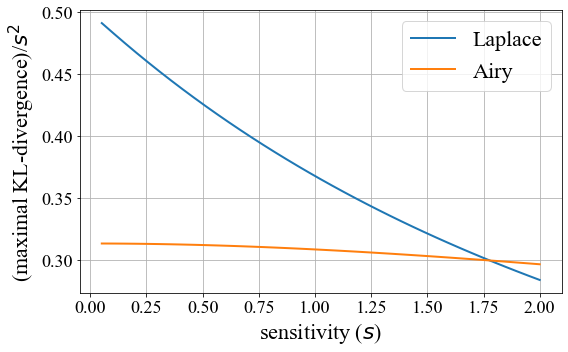

In [4]:
'''
We fix the L1-cost=1 and sen=1.
Plot the Gaussian, Laplace, Airy, Cactus
'''

sampling_probability = 1
sen_grid = np.linspace(0,2,40);
C=1
c_type=1

print("compute kl for laplace")
kl_grid_laplace = [np.abs(compute_kl_general("laplace",C,c_type,sen,sampling_probability)) for sen in sen_grid]

print("compute kl for airy")
kl_grid_airy = [np.abs(compute_kl_general("airy",C,c_type,sen,sampling_probability)) for sen in sen_grid]
    
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(sen_grid, kl_grid_laplace,label = ("Laplace"),linewidth=2)
plt.plot(sen_grid, kl_grid_airy,label = ("Airy"),linewidth=2)
plt.xlabel(r"sensitivity ($s$)",fontsize=22)
plt.xticks(fontsize=18)
plt.ylabel("maximal KL-divergence",fontsize=22)
plt.yticks(fontsize=18)
# plt.title("delta=%.e, L1-cost=1.0, q=%.2f, sen=%.1f" %(delta,sampling_probability,sen),fontsize=15)
plt.legend(loc='best',fontsize=22)
plt.grid()
plt.tight_layout()
plt.savefig('kl_sen2.eps', format='eps')

plt.figure(figsize=(8,5))
plt.plot(sen_grid, kl_grid_laplace/np.power(sen_grid,2),label = ("Laplace"),linewidth=2)
plt.plot(sen_grid, kl_grid_airy/np.power(sen_grid,2),label = ("Airy"),linewidth=2)
plt.xlabel(r"sensitivity ($s$)",fontsize=22)
plt.xticks(fontsize=18)
plt.ylabel(r"(maximal KL-divergence)/$s^2$",fontsize=22)
plt.yticks(fontsize=18)
# plt.title("delta=%.e, L1-cost=1.0, q=%.2f, sen=%.1f" %(delta,sampling_probability,sen),fontsize=15)
plt.legend(loc='best',fontsize=22)
plt.grid()
plt.tight_layout()
plt.savefig('kl_sen.eps', format='eps')